In [1]:
%matplotlib inline

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import cesium as ces
from cesium import datasets

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
eeg = datasets.fetch_andrzejak()

Loaded data from cached archive.


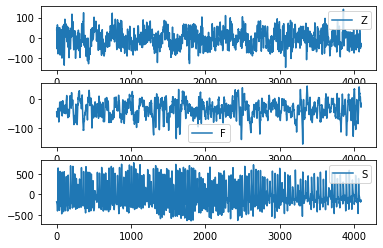

In [3]:
plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg["classes"][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg["classes"][300])
plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg["classes"][450])

In [4]:
features_to_use = ["amplitude", "percent_beyond_1_std", "percent_close_to_median", "skew", "max_slope"]

In [5]:
from cesium import featurize as ft

In [6]:
fset_cesium = ft.featurize_time_series(times = eeg["times"],
                                       values = eeg["measurements"],
                                       errors = None,
                                       features_to_use = features_to_use,
                                      scheduler = None)

In [7]:
fset_cesium.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153


In [8]:
X_train, X_test, y_train, y_test = train_test_split(fset_cesium.values, eeg["classes"], random_state=21)

In [9]:
rf_clf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=21)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [10]:
rf_clf.score(X_test, y_test)

0.616

In [11]:
xgb_clf = xgb.XGBClassifier(n_estimators=10, max_depth=3, random_state=21)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=21,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [12]:
xgb_clf.score(X_test, y_test)

0.648

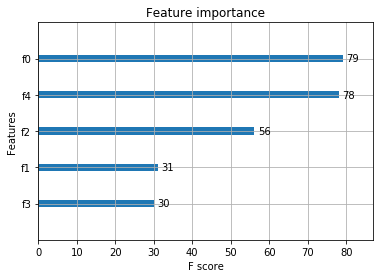

In [13]:
xgb.plot_importance(xgb_clf)

##################

In [14]:
ap = pd.read_csv("../data/AirPassengers.csv", parse_dates=[0])

In [15]:
ap.set_index('Month', inplace=True)

In [16]:
ap.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


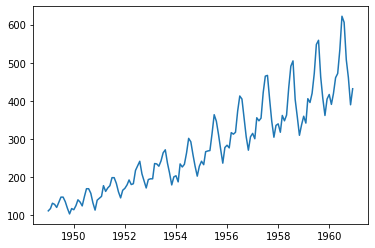

In [17]:
plt.plot(ap)

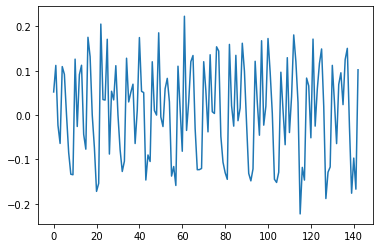

In [18]:
plt.plot(np.diff(np.log(ap.values[:, 0])))

In [19]:
ts = np.diff(np.log(ap.values[:, 0]))

In [20]:
NSTEPS = 12

In [21]:
ts.shape

(143,)

In [22]:
vals = np.hstack([np.expand_dims(np.array(ts, dtype = np.float32), axis = 1) for _ in range(NSTEPS )])

In [23]:
ts[0:NSTEPS]

array([ 0.05218575,  0.1121173 , -0.02298952, -0.06402186,  0.10948423,
        0.0919375 ,  0.        , -0.08455739, -0.13353139, -0.13473259,
        0.12629373, -0.0257525 ])

In [24]:
vals.shape

(143, 12)

In [25]:
nrow = vals.shape[0]
for lag in range(1, vals.shape[1]):
    vals[:(nrow - lag),lag] = vals[lag:,lag]
    vals[(nrow - lag):, lag] = np.nan

In [26]:
vals = vals[:(vals.shape[0] - NSTEPS + 1), :]

In [27]:
vals.shape

(132, 12)

In [28]:
vals[-1]

array([ 0.02919916, -0.06437866,  0.06916336,  0.09552712,  0.02358094,
        0.12528776,  0.15067334, -0.02606011, -0.17639855, -0.0970834 ,
       -0.1672513 ,  0.10227885], dtype=float32)

In [29]:
ts[-NSTEPS:]

array([ 0.02919915, -0.06437866,  0.06916336,  0.09552712,  0.02358094,
        0.12528776,  0.15067335, -0.02606011, -0.17639854, -0.0970834 ,
       -0.1672513 ,  0.10227885])

In [30]:
measures = [vals[i][0:(NSTEPS - 1)] for i in range(vals.shape[0])]

In [31]:
times = [[j for j in range(NSTEPS - 1)] for i in range(vals.shape[0])]

In [32]:
measures[0]

array([ 0.05218575,  0.1121173 , -0.02298952, -0.06402186,  0.10948423,
        0.0919375 ,  0.        , -0.08455739, -0.13353139, -0.13473259,
        0.12629372], dtype=float32)

In [33]:
features_to_use = [
                   "amplitude",
                   "percent_beyond_1_std",
                   "skew",
                   "max_slope",
                   "percent_amplitude"]
fset_ap = ft.featurize_time_series(times=times,
                                    values=measures,
                                    errors=None,
                                    features_to_use=features_to_use,
                                    scheduler = None)

In [34]:
fset_ap.columns = fset_ap.columns.droplevel(-1)

In [35]:
fset_ap.head()

feature,amplitude,percent_beyond_1_std,skew,max_slope,percent_amplitude
0,0.130513,0.454545,-0.155365,0.261026,0.132121
1,0.130513,0.545455,0.051772,0.261026,0.128461
2,0.130513,0.545455,0.037850,0.261026,0.128461
3,0.130513,0.454545,-0.192651,0.261026,0.132121
4,0.130513,0.454545,-0.233966,0.261026,0.132121


(array([15.,  7.,  5., 23., 26., 17.,  6.,  6., 16., 11.]),
 array([0.12786029, 0.1352786 , 0.14269691, 0.15011522, 0.15753352,
        0.16495183, 0.17237014, 0.17978845, 0.18720675, 0.19462506,
        0.20204337]),
 <a list of 10 Patch objects>)

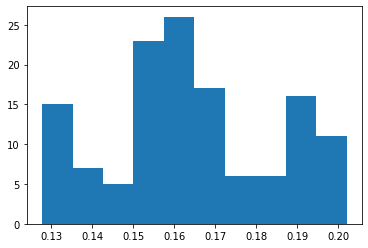

In [36]:
plt.hist(fset_ap.amplitude)

(array([16., 40., 35.,  4., 15.,  9.,  1.,  9.,  2.,  1.]),
 array([0.12414427, 0.14138614, 0.15862801, 0.17586988, 0.19311176,
        0.21035363, 0.2275955 , 0.24483737, 0.26207924, 0.27932111,
        0.29656298]),
 <a list of 10 Patch objects>)

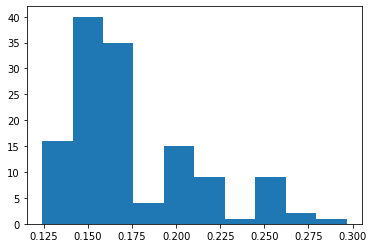

In [37]:
plt.hist(fset_ap.percent_amplitude)

(array([ 9., 11.,  8., 23., 26., 25., 18.,  9.,  2.,  1.]),
 array([-0.56547007, -0.45117751, -0.33688495, -0.22259239, -0.10829984,
         0.00599272,  0.12028528,  0.23457784,  0.3488704 ,  0.46316296,
         0.57745551]),
 <a list of 10 Patch objects>)

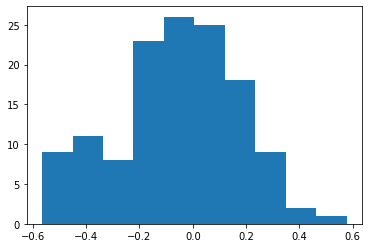

In [38]:
plt.hist(fset_ap['skew'])

In [39]:
outcomes = vals[:, -1]

In [40]:
X_train, y_train = fset_ap.iloc[:100, :], outcomes[:100]
X_test, y_test   = fset_ap.iloc[100:, :], outcomes[100:]

In [41]:
X_train.shape

(100, 5)

In [42]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)

In [43]:
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

[11:39:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.454853
[1]	validation_0-rmse:0.408914
[2]	validation_0-rmse:0.367291
[3]	validation_0-rmse:0.330652
[4]	validation_0-rmse:0.297609
[5]	validation_0-rmse:0.269572
[6]	validation_0-rmse:0.241831
[7]	validation_0-rmse:0.219749
[8]	validation_0-rmse:0.198331
[9]	validation_0-rmse:0.178537
[10]	validation_0-rmse:0.161809
[11]	validation_0-rmse:0.149125
[12]	validation_0-rmse:0.137653
[13]	validation_0-rmse:0.128714
[14]	validation_0-rmse:0.122771
[15]	validation_0-rmse:0.118241
[16]	validation_0-rmse:0.114619
[17]	validation_0-rmse:0.112702
[18]	validation_0-rmse:0.112149
[19]	validation_0-rmse:0.112382


/usr/local/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=21,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

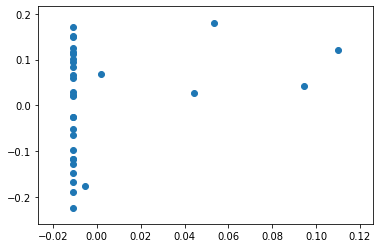

In [44]:
plt.scatter(model.predict(X_test), y_test)

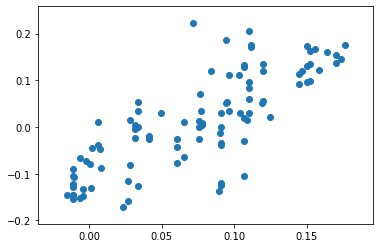

In [45]:
plt.scatter(model.predict(X_train), y_train)

In [46]:
np.corrcoef(model.predict(X_train), y_train)

array([[1.        , 0.77632536],
       [0.77632536, 1.        ]])

In [47]:
np.corrcoef(model.predict(X_test), y_test)

array([[1.       , 0.2657518],
       [0.2657518, 1.       ]])

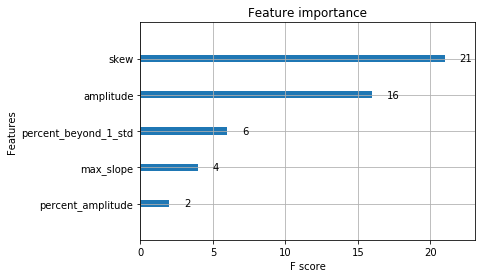

In [48]:
xgb.plot_importance(model)

In [49]:
fset_ap.head()

feature,amplitude,percent_beyond_1_std,skew,max_slope,percent_amplitude
0,0.130513,0.454545,-0.155365,0.261026,0.132121
1,0.130513,0.545455,0.051772,0.261026,0.128461
2,0.130513,0.545455,0.037850,0.261026,0.128461
3,0.130513,0.454545,-0.192651,0.261026,0.132121
4,0.130513,0.454545,-0.233966,0.261026,0.132121


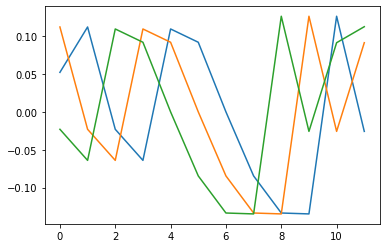

In [50]:
plt.plot(vals[0])
plt.plot(vals[1])
plt.plot(vals[2])


In [51]:
feats = np.zeros( (vals.shape[0], 6), dtype = np.float32)
for i in range(vals.shape[0]):
    feats[i, 0] = np.where(vals[i] == np.max(vals[i]))[0][0]
    feats[i, 1] = np.where(vals[i] == np.min(vals[i]))[0][0]
    feats[i, 2] = feats[i, 0] - feats[i, 1]
    feats[i, 3] = np.max(vals[i][-3:])
    feats[i, 4] = vals[i][-1] - vals[i][-2]
    feats[i, 5] = vals[i][-1] - vals[i][-3]

In [52]:
feats[0:3]

array([[10.        ,  9.        ,  1.        ,  0.12629372, -0.15204622,
         0.10898009],
       [ 9.        ,  8.        ,  1.        ,  0.12629372,  0.11710228,
        -0.03494394],
       [ 8.        ,  7.        ,  1.        ,  0.11247798,  0.0211282 ,
         0.13823047]], dtype=float32)

In [53]:
X_train, y_train = feats[:100, :], outcomes[:100]
X_test, y_test   = feats[100:, :], outcomes[100:]

In [54]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

[11:39:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.459744
[1]	validation_0-rmse:0.418616
[2]	validation_0-rmse:0.380625
[3]	validation_0-rmse:0.346577
[4]	validation_0-rmse:0.315931
[5]	validation_0-rmse:0.287931
[6]	validation_0-rmse:0.263988
[7]	validation_0-rmse:0.241361
[8]	validation_0-rmse:0.222136
[9]	validation_0-rmse:0.205052
[10]	validation_0-rmse:0.189806
[11]	validation_0-rmse:0.175841
[12]	validation_0-rmse:0.162495
[13]	validation_0-rmse:0.150479
[14]	validation_0-rmse:0.139907
[15]	validation_0-rmse:0.131403
[16]	validation_0-rmse:0.122909
[17]	validation_0-rmse:0.115215
[18]	validation_0-rmse:0.108389
[19]	validation_0-rmse:0.102514


/usr/local/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=21,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

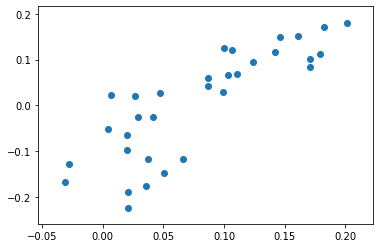

In [55]:
plt.scatter(model.predict(X_test), y_test)

In [56]:
print(np.corrcoef(model.predict(X_test), y_test))

[[1.         0.82957102]
 [0.82957102 1.        ]]


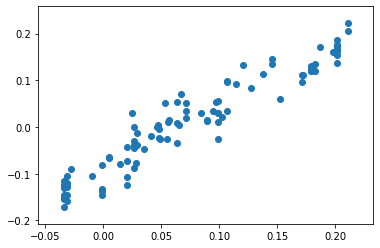

In [57]:
plt.scatter(model.predict(X_train), y_train)

In [58]:
np.corrcoef(model.predict(X_train), y_train)

array([[1.        , 0.95743121],
       [0.95743121, 1.        ]])